# Re-writing DLT to follow R. Hyndman's 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from orbit.dlt_rh import DLTRH
from orbit.dlt import DLT
import numpy as np
from orbit.models import get_compiled_stan_model
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.backtest.functions import run_multi_series_backtest

In [2]:
DATA_FILE = "./data/iclaims_example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
response_col = 'claims'

In [8]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


In [9]:
mod = DLTRH(
    is_multiplicative=True, seed=2020,
    response_col='claims', date_col='week', seasonality=52, 
    normalize_seasonality=1,
    infer_method='map', predict_method='map')

In [10]:
mod.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e218fcd7f9163bb2851e7fdd089f7cb0 NOW.


In [11]:
fit = mod.aggregated_posteriors['map']

In [12]:
fit.keys()

dict_keys(['l', 'b', 'l_sm', 'b_sm', 'obs_sigma', 'gb', 'gt_sum', 's', 's_sm'])

In [13]:
s = fit['s']
l = fit['l']
gb = fit['gb']
l_ext = np.expand_dims(np.tile(l[:, -1], 51), 0)
l = np.concatenate([l, l_ext], axis=1)

In [14]:
gb

array([-0.00178721])

In [15]:
b = fit['b']
b_ext = [b[:, -1] * mod.damped_factor]
for i in range(2,52):
    b_ext.append(b_ext[-1] * mod.damped_factor)
b_ext = np.array(b_ext).reshape(1, -1)
b = np.concatenate([b, b_ext], axis=1)

In [16]:
gt = gb * np.arange(0, l.shape[1])
gt = gt.reshape(1, -1)

In [17]:
print(l.shape, s.shape, b.shape, l_ext.shape, b_ext.shape, gt.shape)

(1, 443) (1, 443) (1, 443) (1, 51) (1, 51) (1, 443)


In [18]:
yhat= gt + l + s + b
yhat =np.squeeze(yhat)

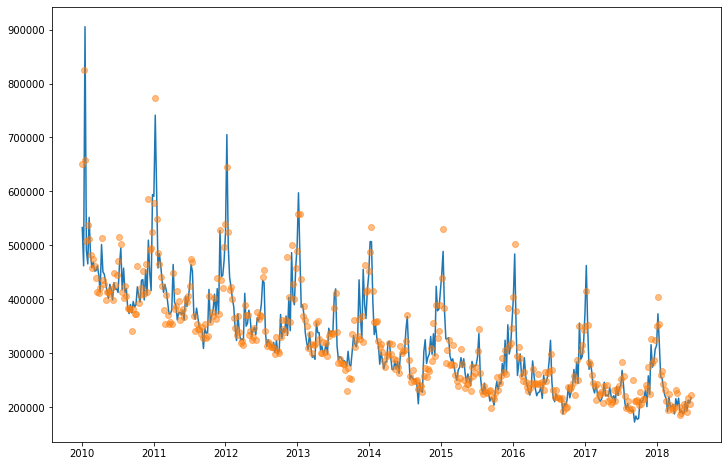

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(df['week'], np.exp(yhat))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

In [20]:
predicted_df = mod.predict(df)

In [21]:
predicted_df.tail(52)

,week,prediction
391,2017-07-02,239945.085612
392,2017-07-09,268510.782229
393,2017-07-16,241038.908397
394,2017-07-23,207839.832634
395,2017-07-30,196261.337423
396,2017-08-06,207109.087855
397,2017-08-13,196375.971642
398,2017-08-20,194028.772497
399,2017-08-27,192918.846549
400,2017-09-03,195105.643358


In [22]:
np.exp(yhat[-52:])

array([239945.08561164, 268510.78222905, 241038.90839703, 207839.83263426,
       196261.33742267, 207109.08785472, 196375.97164235, 194028.77249735,
       192918.84654891, 195105.64335812, 172810.90989874, 183949.83531286,
       177770.6270306 , 179710.74572595, 214056.89986128, 209338.6970904 ,
       212473.25281825, 220194.02306824, 232069.52948074, 201244.65646062,
       258448.1109942 , 224156.40117207, 316121.25422735, 274438.26492468,
       283017.02385277, 307692.03128122, 314714.00123986, 373394.50692732,
       318002.46712009, 256431.24789666, 254230.45428037, 234953.67125129,
       222280.12836192, 215940.99795718, 192186.56613857, 219809.73808607,
       200065.55000182, 202061.78583264, 205262.68072204, 187739.06471514,
       215980.99550423, 203059.52083022, 217067.49675253, 190038.26132645,
       194605.68062651, 187721.62632224, 191180.40947524, 211126.09978126,
       192972.9919147 , 213332.30609783, 207964.97383157, 217747.6976956 ])

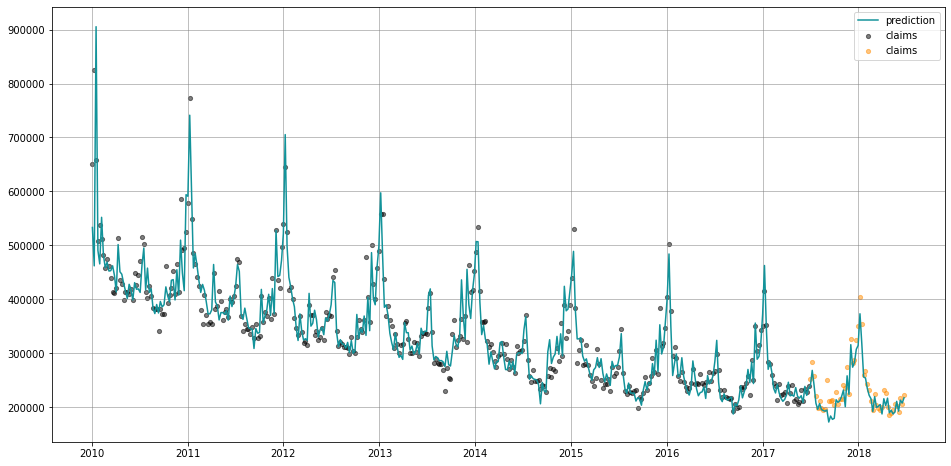

In [23]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=mod.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [24]:
# backtest on more data
# data = pd.read_csv('./data/uber_uscan_rider_uFT.csv', parse_dates=['event_week'])
# data = pd.read_csv('./data/uber_uscan_driver_uFT.csv', parse_dates=['event_week'])
# response_col = 'uFT'
# date_col='event_week'
# key_col = 'city_name'
# predicted_col='prediction'

data = pd.read_csv('./data/m3_monthly.csv', parse_dates=['date'])
response_col = 'value'
date_col='date'
key_col = 'key'
predicted_col='prediction'

In [25]:
data.dtypes

key              object
value           float64
date     datetime64[ns]
dtype: object

In [26]:
uni_keys = data[key_col].unique()

###  Expanding window

In [27]:
# min_train_len = 380
# forecast_len = 26
# incremental_len = 13
# n_splits=2
# key_col = "city_name"
# window_type = 'expanding'
# seasonality=52

min_train_len = 380
forecast_len = 18
incremental_len = 18
n_splits=1
window_type = 'expanding'
seasonality=12
seed=2019

Instantiate a model that we want to backtest

In [32]:
mod = DLTRH(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    normalize_seasonality=0,
    infer_method='map', predict_method='map')

In [33]:
%%time
bt_result, bt_scores = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:49<00:00,  8.28it/s]


CPU times: user 1min 51s, sys: 5.54 s, total: 1min 56s
Wall time: 2min 50s


In [34]:
bt_scores['smape'].mean()

0.16028087353019924

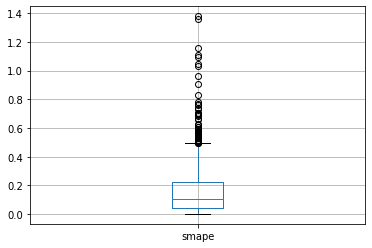

In [35]:
bt_scores.boxplot(column='smape')

In [45]:
mod2 = DLT(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    infer_method='map', predict_method='map')

In [46]:
%%time
bt_result2, bt_scores2 = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod2,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:02<00:00, 11.39it/s]


CPU times: user 1min 53s, sys: 5.8 s, total: 1min 59s
Wall time: 2min 4s


In [47]:
bt_scores2['smape'].mean()

0.14827365152127073

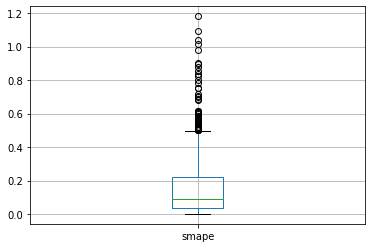

In [48]:
bt_scores2.boxplot(column='smape')

In [ ]:
# TODO:
# compare 
# 1. using normalize vs. not use -- non-normalized is better 
# 2. subtract init lev by s[1] vs. by s[SEASONALITY] -- after some thought, s[SEASONALITY]
# should be the right one
# 3. changing different ways to get init_lev prior -- using l[1] seems even worse
# 4. random initialize seasonality vs. random normal initialization -- not too much difference
# 5. changing NUs of student t to see if letting stan to optimize makes better accuracy
# tried 10 vs. 5 doesn't matter (when normalizing)